<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb&fileName=gefcom14-s-deepar"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Download data

In [1]:
!echo "Downloading GEFCom14-S..."
!rm -R data > /dev/null
!wget -O gefcom14.zip https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0
!unzip gefcom14 > /dev/null
!rm gefcom14.zip > /dev/null
!unzip GEFCom2014\ Data/GEFCom2014-S_V2.zip > /dev/null
!rm -R GEFCom2014\ Data > /dev/null
!mv Solar data > /dev/null
!echo "------------------------------"
!echo "Downloaded GEFCom14-S in data/"

"Downloading GEFCom14-S..."


Das System kann den angegebenen Pfad nicht finden.
Der Befehl "wget" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Das System kann den angegebenen Pfad nicht finden.
Das System kann den angegebenen Pfad nicht finden.
Das System kann den angegebenen Pfad nicht finden.
Das System kann den angegebenen Pfad nicht finden.
Das System kann den angegebenen Pfad nicht finden.


"------------------------------"
"Downloaded GEFCom14-S in data/"


# Install pip packages

In [2]:
#!pip install mxnet
#!pip install gluonts

# Select Task

In [3]:
task = 6

In [4]:
import pandas as pd

predictors = pd.read_csv(f'data/Task {task}/predictors{task}.csv', parse_dates=['TIMESTAMP'])\
    [['ZONEID', 'TIMESTAMP', 'VAR164', 'VAR169', 'VAR175', 'VAR178', 'VAR228']].set_index('TIMESTAMP')
train = pd.read_csv(f'data/Task {task+1}/train{task+1}.csv', parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')
benchmark = pd.read_csv(f"data/Task {task}/benchmark{'0' + str(task) if task < 10 else task}.csv",
                        parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')

In [5]:
solar_plants = [train[train['ZONEID'] == i][['POWER']].rename({'POWER': f'ZONEID {i}'}, axis='columns')
                for i in [1,2,3]]
train_data = pd.concat(solar_plants, axis=1)
train_data

,ZONEID 1,ZONEID 2,ZONEID 3
TIMESTAMP,,,
2012-04-01 01:00:00,0.754103,0.647328,0.799000
2012-04-01 02:00:00,0.555000,0.621822,0.817500
2012-04-01 03:00:00,0.438397,0.472692,0.571500
2012-04-01 04:00:00,0.145449,0.098866,0.063775
2012-04-01 05:00:00,0.111987,0.104393,0.103700
...,...,...,...
2013-09-30 20:00:00,0.002564,0.000182,0.002925
2013-09-30 21:00:00,0.065769,0.050466,0.108050
2013-09-30 22:00:00,0.383462,0.162814,0.335075


In [6]:
def get_predictor_ids():
    return ['VAR169', 
            'VAR175', 
            'VAR178', 
            'VAR228', 
            'VAR164']
def get_predictor_names(i):
    return [f'SSRD {i}', 
            f'STRD {i}', 
            f'TSR {i}', 
            f'TP {i}', 
            f'TCC {i}']

# add total cloud cover * surface solar radiation predictor
# predictors['VAR164*169'] = predictors['VAR164'] * predictors['VAR169']

In [7]:
predictors_categories = [predictors[predictors['ZONEID'] == i][get_predictor_ids()]
                             .rename(dict(zip(get_predictor_ids(), get_predictor_names(i))), 
                                     axis='columns')
                         for i in [1,2,3]]
predictor_data = pd.concat(predictors_categories, axis=1)

In [8]:
# decumulate data

from itertools import product

for name, zoneid in product(['SSRD', 'STRD', 'TSR'], range(1, 4)):
    subtract = predictor_data[f'{name} {zoneid}'].copy()
    subtract.iloc[1:] = subtract[:-1]
    subtract.iloc[::24] = 0

    predictor_data[f'{name} {zoneid}'] -= subtract

<AxesSubplot:xlabel='TIMESTAMP'>

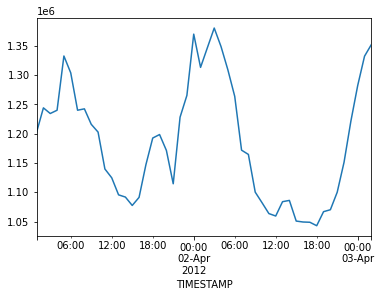

In [9]:
predictor_data['STRD 1'].iloc[:50].plot()

In [10]:
for i in range(1, 4):
    for name in get_predictor_names(i):
        predictor_data[name] /= predictor_data[name].max()
predictor_data

,SSRD 1,STRD 1,TSR 1,TP 1,TCC 1,SSRD 2,STRD 2,TSR 2,TP 2,TCC 2,SSRD 3,STRD 3,TSR 3,TP 3,TCC 3
TIMESTAMP,,,,,,,,,,,,,,,
2012-04-01 01:00:00,0.635857,0.749657,0.673847,0.000000,0.244599,0.640101,0.759791,0.676489,0.000000,0.190965,0.642143,0.761533,0.676487,0.000000,0.238145
2012-04-01 02:00:00,0.685296,0.775649,0.727011,0.000000,0.457135,0.685574,0.782928,0.726961,0.000000,0.517131,0.676576,0.777657,0.717798,0.013823,0.561610
2012-04-01 03:00:00,0.632863,0.769635,0.703986,0.028372,0.771424,0.612531,0.779600,0.690515,0.024993,0.705216,0.581839,0.782524,0.662463,0.029863,0.661607
2012-04-01 04:00:00,0.478215,0.773120,0.563346,0.052930,0.965860,0.459050,0.791259,0.546270,0.034330,0.993355,0.469348,0.794740,0.549285,0.037236,0.941552
2012-04-01 05:00:00,0.316365,0.830914,0.417683,0.070487,0.944662,0.329087,0.845299,0.427011,0.041639,0.937597,0.353450,0.837820,0.443191,0.045280,0.944677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-09-30 20:00:00,0.002060,0.666867,0.003700,0.000000,0.999993,0.001997,0.678457,0.003745,0.000000,0.999992,0.001932,0.698009,0.003722,0.000000,0.999992
2013-09-30 21:00:00,0.049585,0.702975,0.078494,0.000000,0.999993,0.051411,0.711864,0.079918,0.000000,0.999992,0.054887,0.722792,0.082189,0.000000,0.999992
2013-09-30 22:00:00,0.268181,0.657013,0.300805,0.000000,0.999993,0.265817,0.670421,0.298929,0.000000,0.999992,0.266976,0.681977,0.299485,0.000000,0.999992


In [11]:
# define the parameters of the dataset
gefcom14_metadata = {'num_series': 3,
                     'num_steps': len(predictor_data),
                     'prediction_length': len(benchmark) // 3, # three different timezones
                     'freq': '1H',
                     'start': [pd.Timestamp(predictor_data.index[0], freq='1H') for _ in range(3)]
                     }

In [12]:
targets = [train_data[:-gefcom14_metadata['prediction_length']][f'ZONEID {i}'].values for i in [1,2,3]]
starts = gefcom14_metadata['start']
features = [predictor_data[:-gefcom14_metadata['prediction_length']][get_predictor_names(i)].values.T for i in [1,2,3]]

In [13]:
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

train_ds = ListDataset([{
    FieldName.TARGET: target,
    FieldName.START: start,
    FieldName.FEAT_DYNAMIC_REAL: fdr,
    FieldName.FEAT_STATIC_CAT: [fsc]
  } for (target, start, fdr, fsc) in zip(targets, starts, features, [1,2,3])], 
  freq=gefcom14_metadata['freq'])

In [14]:
targets = [train_data[f'ZONEID {i}'].values for i in [1,2,3]]
starts = gefcom14_metadata['start']
features = [predictor_data[get_predictor_names(i)].values.T for i in [1,2,3]]

In [15]:
test_ds = ListDataset([{
    FieldName.TARGET: target,
    FieldName.START: start,
    FieldName.FEAT_DYNAMIC_REAL: fdr,
    FieldName.FEAT_STATIC_CAT: [fsc]
  } for (target, start, fdr, fsc) in zip(targets, starts, features, [1,2,3])], 
  freq=gefcom14_metadata['freq'])

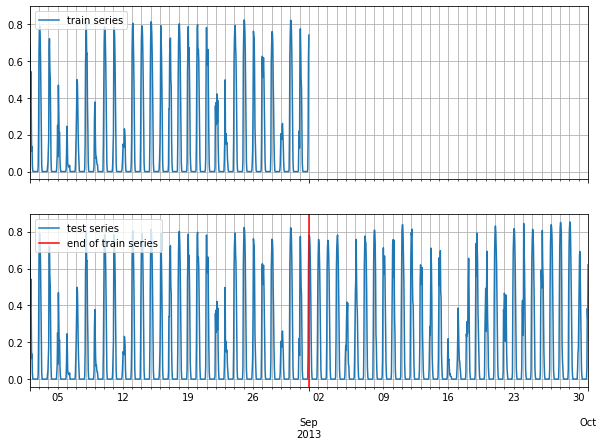

In [16]:
from gluonts.dataset.util import to_pandas
import matplotlib.pyplot as plt

train_entry = next(iter(train_ds))
test_entry = next(iter(test_ds))

train_series = to_pandas(train_entry)
test_series = to_pandas(test_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series[-24*30:].plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series[-24*30-gefcom14_metadata['prediction_length']:].plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [17]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.mx.distribution import PiecewiseLinearOutput

estimator = DeepAREstimator(freq=gefcom14_metadata['freq'],
                            prediction_length=gefcom14_metadata['prediction_length'],
                            distr_output=PiecewiseLinearOutput(num_pieces=3), # SQF-RNN
                            use_feat_dynamic_real=True,
                            trainer=Trainer(epochs=7))

ensemble_count = 7
predictors = []

for _ in range(ensemble_count):
    predictor = estimator.train(train_ds)
    predictors.append(predictor)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [01:19<00:00,  1.59s/it, epoch=7/7, avg_epoch_loss=0.0224]


In [18]:
from gluonts.evaluation.backtest import make_evaluation_predictions
from tqdm import tqdm

forecast_ensemble = []
tss_ensemble = []

for predictor in tqdm(predictors):
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=500,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    forecast_ensemble.append(forecasts)
    tss_ensemble.append(tss)

100%|██████████| 7/7 [03:46<00:00, 32.43s/it]


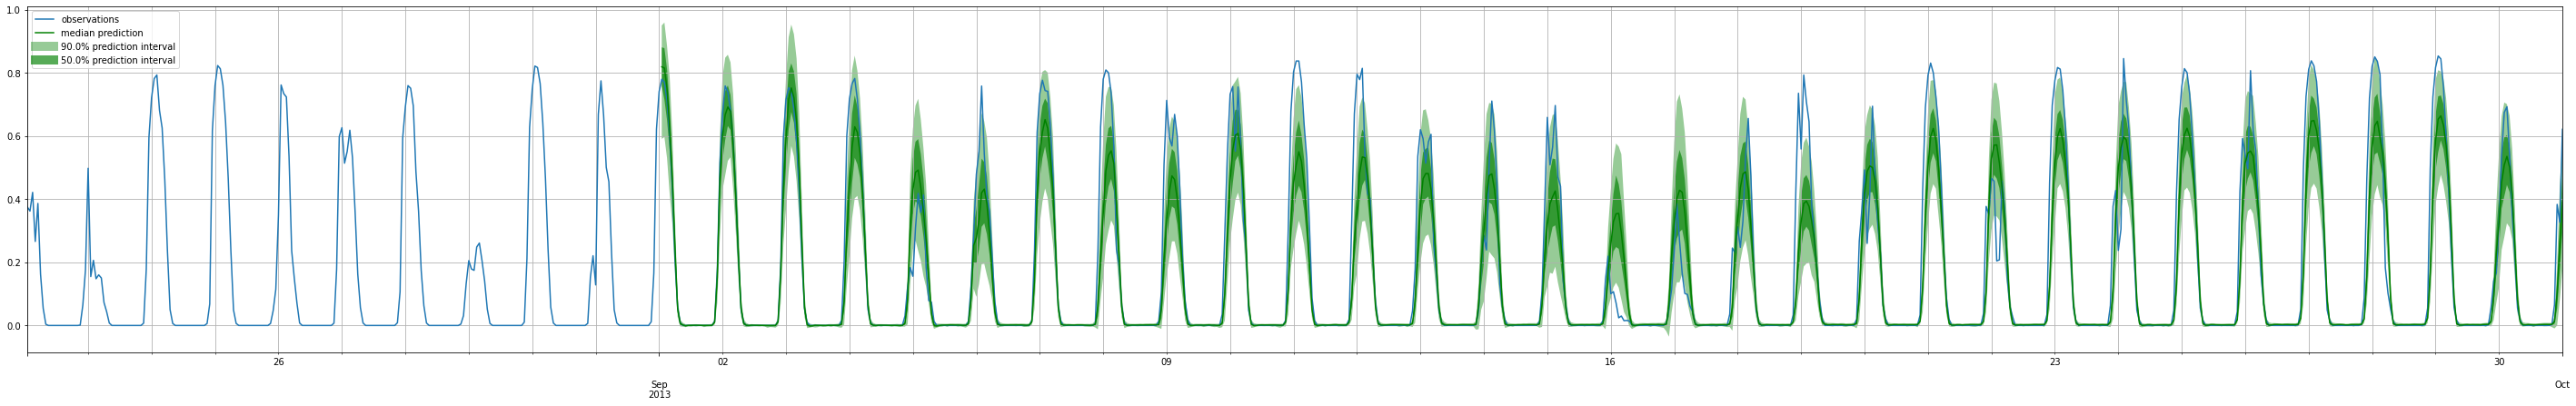

In [19]:
def plot_prob_forecasts(ts_entry, forecast_entry, output_file=None):
    plot_length = 24 * 40
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(50, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    if output_file is not None:
        plt.savefig(output_file)
    plt.show()

plot_prob_forecasts(tss[0], forecasts[0])

In [20]:
import numpy as np

prediction_ensemble = []

for forecasts in forecast_ensemble:
    zone_predictions = []
    for i, forecast in enumerate(forecasts):
        prediction = pd.concat([np.maximum(forecast.quantile_ts(p/100), 0)
                                for p in range(1, 100)], axis=1)\
            .rename(columns={p: str((p+1)/100) for p in range(99)})
        prediction.insert(0, 'ZONEID', i+1)
        prediction.index.name = 'TIMESTAMP'
        zone_predictions.append(prediction)

    predictions = pd.concat(zone_predictions)
    prediction_ensemble.append(predictions)

In [21]:
#!mkdir -p results

In [22]:
averaged_predictions = pd.DataFrame()

for p in range(1, 100):
    quantile_columns = [prediction[str(p/100)] for prediction in prediction_ensemble]
    averaged_predictions.insert(p-1, str(p/100), np.mean(quantile_columns, axis=0))

averaged_predictions.insert(0, 'ZONEID', np.array(prediction_ensemble[0]['ZONEID']))
averaged_predictions.insert(0, 'TIMESTAMP', prediction_ensemble[0].index)
averaged_predictions = averaged_predictions.set_index('TIMESTAMP')
    
#averaged_predictions.to_csv(f'results/prediction_deepar_task{task}.csv')

averaged_predictions

,ZONEID,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,...,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2013-09-01 01:00:00,1,0.631919,0.637046,0.642346,0.647024,0.651324,0.656287,0.660418,0.664867,0.670590,...,0.907868,0.911141,0.916883,0.922618,0.926892,0.931765,0.935650,0.940506,0.944824,0.949128
2013-09-01 02:00:00,1,0.620270,0.639067,0.646019,0.653227,0.662557,0.668717,0.673445,0.678106,0.684456,...,0.919011,0.923005,0.928816,0.934821,0.939007,0.944952,0.952252,0.960350,0.971391,0.985571
2013-09-01 03:00:00,1,0.570805,0.590055,0.598843,0.609523,0.618198,0.623953,0.629342,0.635210,0.641080,...,0.867755,0.871747,0.876034,0.881544,0.885248,0.890805,0.897647,0.905102,0.916391,0.928626
2013-09-01 04:00:00,1,0.460281,0.472730,0.485394,0.495025,0.501079,0.507694,0.514169,0.520121,0.524451,...,0.735151,0.740165,0.744246,0.749958,0.754833,0.760805,0.769534,0.781999,0.792197,0.812838
2013-09-01 05:00:00,1,0.310319,0.321979,0.337505,0.344047,0.351145,0.357509,0.361663,0.365728,0.369588,...,0.553787,0.556968,0.562036,0.568343,0.575789,0.581024,0.587828,0.597722,0.605468,0.620299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-09-30 20:00:00,3,0.000000,0.000008,0.000176,0.000291,0.000327,0.000360,0.000391,0.000428,0.000446,...,0.004644,0.004959,0.005280,0.005786,0.006418,0.007102,0.007841,0.008496,0.009245,0.010051
2013-09-30 21:00:00,3,0.000000,0.000405,0.000570,0.000912,0.001247,0.001432,0.001552,0.001741,0.001891,...,0.031987,0.033315,0.034227,0.035746,0.037045,0.038843,0.040800,0.043064,0.046015,0.051755
2013-09-30 22:00:00,3,0.010816,0.013805,0.016787,0.019058,0.021149,0.023733,0.026999,0.029177,0.031808,...,0.194516,0.198401,0.201928,0.205174,0.209155,0.214648,0.221157,0.229869,0.238110,0.256481


## Plotting the quantile prediction for the first entries

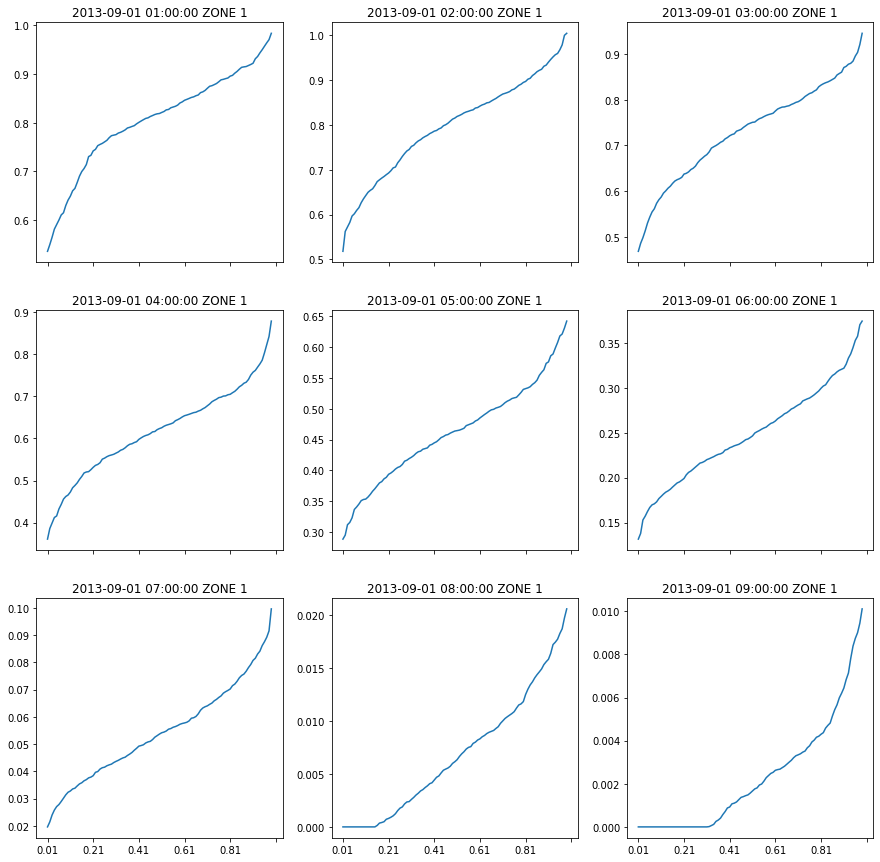

In [23]:
fig, ax = plt.subplots(3, 3, sharex=True, figsize=(15, 15))

for i in range(9):
    predictions.iloc[i].tail(99).plot(ax=ax[i // 3, i % 3], 
                                      title=str(predictions.index[i]) + ' ZONE ' 
                                      + str(int(predictions.iloc[i]['ZONEID'])))

# Evaluate Loss

The loss function is the pinnball loss: 
$$ L(q_a, y) = \begin{cases}
    (1-\frac{a}{100})(q_a - y), &\text{if } y < q_a \\
    \frac{a}{100}(y-q_a), &\text{if } y \geq q_a.
\end{cases} $$

The score is then averaged over all target quantiles for all time periods over the forecast horizon and for all zones.

In [24]:
def pinnball_loss(actual, prediction):
    actual = actual[...,None]

    percentiles = np.empty((actual.shape[0], 99))
    for i in range(1, 100):
        percentiles[:, i-1] = i
    loss = np.where(actual < prediction, 
                    (1 - percentiles / 100) * (prediction - actual), 
                    percentiles / 100 * (actual - prediction))
    return loss

loss1 = np.mean(pinnball_loss(tss[0].values[-gefcom14_metadata['prediction_length']:,0], predictions[predictions['ZONEID'] == 1].drop('ZONEID', axis=1)))
loss2 = np.mean(pinnball_loss(tss[1].values[-gefcom14_metadata['prediction_length']:,0], predictions[predictions['ZONEID'] == 2].drop('ZONEID', axis=1)))
loss3 = np.mean(pinnball_loss(tss[2].values[-gefcom14_metadata['prediction_length']:,0], predictions[predictions['ZONEID'] == 3].drop('ZONEID', axis=1)))

print(f"Loss of task {task}: {round((loss1 + loss2 + loss3) / 3, 5)}")

Loss of task 6: 0.02627


In [25]:
loss1 = np.mean(pinnball_loss(tss[0].values[-gefcom14_metadata['prediction_length']:,0], benchmark[benchmark['ZONEID'] == 1].drop('ZONEID', axis=1)))
loss2 = np.mean(pinnball_loss(tss[1].values[-gefcom14_metadata['prediction_length']:,0], benchmark[benchmark['ZONEID'] == 2].drop('ZONEID', axis=1)))
loss3 = np.mean(pinnball_loss(tss[2].values[-gefcom14_metadata['prediction_length']:,0], benchmark[benchmark['ZONEID'] == 3].drop('ZONEID', axis=1)))

print(f"Benchmark loss of task {task}: {round((loss1 + loss2 + loss3) / 3, 5)}")

Benchmark loss of task 6: 0.03591
